In [1]:
import robotworld as r
import numpy as np
import GPy
import maxint_opt as opt
import matplotlib.pyplot as plt


In [2]:
p = r.PWorld()

In [3]:
# maintain gp that takes a,s -> value (this is the Q function)
B = np.identity(2)*0.05

def q_estimate2(VGP,gp,s):
    def f(x):
#         return p.RGP.predict(x[:,:2])[0] + VGP.predict(x[:,:2])[0]
        return p.reward(s[0],s[1]) + 0.9*VGP.predict(x[:,:2])[0]
    for i in range(20):
        actions = np.random.uniform(0,2*np.pi, (180, 1))
        def UCB(gp):
            def f(a):
                val = opt.integrate(gp,p.angle_delta_np(s,a),B)
#                 print val
                return val[0] + 3.0*np.sqrt(val[1])
            return f
        acq_val = np.apply_along_axis(UCB(gp), 1, actions)
        index = acq_val.argmax()
        maxa = actions[index]
        _,_,z = opt.integrate(gp,p.angle_delta_np(s,maxa),B)
        xs = np.random.uniform(s - [1,1],s + [1,1], (100, 2))
        chosen = opt.bq_acquisition2(gp, p.angle_delta_np(s,maxa),B, xs,z,1)
        X = gp.X
        Y = gp.Y
        newX = chosen
        Xnew = np.vstack((X, newX))
        Yadd = newX.copy()
        Yadd = f(Yadd)
        Ynew = np.vstack((Y, Yadd))
        gp = GPy.models.GPRegression(Xnew, Ynew, GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)
    actions = np.reshape(np.linspace(0, 2*np.pi, 360),(-1,1))
    def VAL(gp):
        def f(a):
            val = opt.integrate(gp,p.angle_delta_np(s,a),B)
            return val[0]
        return f
    acq_val = np.apply_along_axis(VAL(gp), 1, actions)
    index = acq_val.argmax()
    maxa = actions[index]
    return maxa[0], acq_val[index]

In [4]:
s = np.array([[19.0,19.0]])
gp = GPy.models.GPRegression(s, VGP.predict(s)[0], GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)
maxa, value = q_estimate2(VGP,gp,s[0,:])
print maxa, value

NameError: name 'VGP' is not defined

In [23]:
# MODEL A
def plot_reference(m,s):
    actions = np.reshape(np.linspace(0, 2*np.pi, 300),(-1,1))
    mus = []
    var = []
    tot = []
    for a in actions:
        out = opt.integrate_dim(m,2, a, p.angle_delta_np(s,a),B)
        mus.append(out[0])
        var.append(2.0*np.sqrt(out[1]))
        tot.append(out[0] + 2.0*np.sqrt(out[1]))
    plt.plot(actions, mus,label='mu')
    plt.plot(actions, var,label='b*sig')
    plt.plot(actions, tot,label='UCB')
    plt.legend(loc='upper left')
    plt.show()
plot_reference(gps[15],np.array([17.0,17.0]))

def plot_error(gp,s):
    actions = np.reshape(np.linspace(0, 2*np.pi, 300),(-1,1))
    preds = np.array([])
    for a in actions:
        preds = np.append(preds,opt.integrate_dim(gp, 2, a, p.angle_delta_np(s,a),B)[0])
    print actions[preds.argmax()], preds.max()
    plt.plot(actions, preds,label='gp')
    plt.legend(loc='upper left')
    plt.show()
# plot_error(gps[-1],np.array([17.0,17.0]))

IndexError: list index out of range

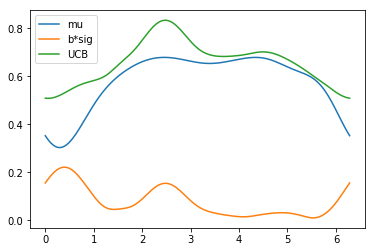

In [27]:
def plot_reference(m,s):
    actions = np.reshape(np.linspace(0, 2*np.pi, 300),(-1,1))
    mus = []
    var = []
    tot = []
    for a in actions:
        out = opt.integrate(m,p.angle_delta_np(s,a),B)
        mus.append(out[0])
        var.append(2.0*np.sqrt(out[1]))
        tot.append(out[0] + 2.0*np.sqrt(out[1]))
    plt.plot(actions, mus,label='mu')
    plt.plot(actions, var,label='b*sig')
    plt.plot(actions, tot,label='UCB')
    plt.legend(loc='upper left')
    plt.show()
plot_reference(gps[3],np.array([20.0,20.0]))

def plot_error(gp,s):
    actions = np.reshape(np.linspace(0, 2*np.pi, 300),(-1,1))
    preds = np.array([])
    for a in actions:
        preds = np.append(preds,opt.integrate_dim(gp, 2, a, p.angle_delta_np(s,a),B)[0])
    print actions[preds.argmax()], preds.max()
    plt.plot(actions, preds,label='gp')
    plt.show()
# plot_error(gps[-1],np.array([17.0,17.0]))

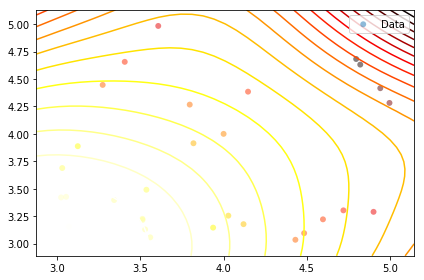

In [49]:
gps[-1].plot()

In [ ]:
GPS = []
def RTDP():
    D = {}
    for (x,y) in p.supports:
        if p.in_obstacle(x,y):
            D[(x,y)] = 0.0
        else: 
            D[(x,y)] = 30.0*0.9**p.norm(p.goalX,p.goalY,x,y)
    VGP, _, _ = p.GPFromDict(D)
    GPS.append(VGP)
    VGP = GPS[-1]

    def TrialRecurseWrapper(ax,ay,VGP):
        def TrialRecurse(x,y,VGP,iters,hit=False,):
            print (x,y)
            if p.in_goal(x,y) or hit or iters>50:
                return
            s = np.array([[x,y]])
            gp = GPy.models.GPRegression(s, VGP.predict(s)[0], GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)
            maxa, value = q_estimate2(VGP,gp,s[0,:])
            print maxa, value
            (sx,sy),hit = p.transition(x,y,maxa)

            TrialRecurse(sx,sy,VGP,iters+1,hit)

            VGP, _,_ = p.GPFromDict(D)
            
            gp = GPy.models.GPRegression(s, VGP.predict(s)[0], GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)
            maxa, value = q_estimate2(VGP,gp,s[0,:])
            newx,newy = p.find_closest_support(x,y)

            D[(newx,newy)] = value
        TrialRecurse(ax,ay,VGP,0)

    for i in range(30):
        print "ITERATION %d" % (i)
        TrialRecurseWrapper(p.startX,p.startY,VGP)
        VGP, _,_ = p.GPFromDict(D)
        GPS.append(VGP)
RTDP()

ITERATION 0
(19.0, 19.0)
3.8854237832698275 2.214395526111616
(17.811584647110116, 18.785225434195514)
3.9729333279380667 2.4729918966904734
(17.263018711938983, 17.89621717734858)
3.9904352368717144 2.757191474678166
(16.313300753072596, 17.197328618118355)
3.9729333279380667 3.1792306482343946
(15.682795259459644, 16.60749654746969)
3.517883695663222 3.4666169927004375
(14.471533923037697, 16.37412425617117)
0.1925209982701266 6.998187839075399
(15.625829629767395, 16.845144690547592)
5.495599405165431 4.068951552325984
(16.2310988091958, 16.146364010657503)
3.3078607884594478 3.3861986095661223
(15.182245832949633, 15.82156069707895)
4.235461961942785 9.562239353686891
(14.236385515989694, 15.0)
ITERATION 1
(19.0, 19.0)
5.18056504435977 1.9306901859060588
(19.701957591522206, 18.133606198802966)
4.200458144075489 1.4887127000658467
(19.18042026095707, 17.325538286802068)
4.3054695976773765 2.4276697401587626
(18.587160781597927, 16.40799920809919)
4.0079371458053625 2.78230445147710

3.0278302455210815 16.190461107013107
(2.257702421751686, 8.676037375007926)
5.268074589028009 13.607448309387024
(2.6826143196905785, 7.77446701126199)
5.810633765971093 15.067479772609659
(3.4115655849358912, 7.126221846701783)
4.5504963227484465 16.199125664996245
(3.271590623212438, 5.7191892441924574)
5.163063135426122 18.352970132730775
(3.7712264368199344, 4.842317406177257)
ITERATION 3
(19.0, 19.0)
0.07000763573459148 1.7747663968231109
(20.087425993828795, 19.27662566716205)
1.7851947112320827 1.1201283330001388
(19.785380952851067, 20.264865349107563)
4.427982960212911 1.3994589411677225
(19.63514280279544, 19.296432073042332)
4.51549250488115 1.47574315284146
(19.494719332439377, 18.214704053445036)
1.6976851665638435 2.076421968063528
(19.78536914802919, 19.212162297902804)
3.692902784999701 0.9295941677792143
(18.864372625417715, 18.507442410289315)
4.375477233411968 1.859293330546393
(18.50489885206172, 17.228437421263333)
4.743017321018573 2.396896702834283
(18.440423766

2.3802596149761106 4.54451954691956
(8.819463706470673, 16.68200294015129)
3.1853474259239123 4.770982535875845
(7.762126406991059, 16.82509320158756)
3.5878913313978136 5.13250492340012
(7.003035240937945, 16.394616676451708)
3.675400876066053 5.3972348417155445
(5.774837699309736, 16.1180432325367)
0.21002290720377445 5.257858748664148
(6.775313840257145, 15.98562206965415)
2.887814974051899 5.38484520772181
(5.910351018725256, 16.03295369680486)
6.265683398245938 6.142106298410113
(6.907639232948698, 16.4508209789086)
3.2903588795257996 5.622548679213196
(5.786625115872131, 16.272735276803555)
0.05250572680094361 5.4612501913161395
(6.753003302119533, 16.4447634932306)
0.4725515412084925 5.23169221135322
(7.967051131045732, 16.808948721764498)
3.4653779688622786 5.10114623313234
(7.2023580433208325, 16.945486002456157)
3.762910420734292 5.313553058877005
(6.679313008709572, 16.475485394364124)
2.6252863400471806 5.3566340048021175
(5.879939930461896, 17.07913882230891)
6.21317767144

0.5600610858767319 9.76130709284189
(17.186807482419784, 6.973607636321047)
3.272856970592152 4.603602508118456
(15.950343791448095, 6.885302804415335)
5.268074589028009 4.27969201304586
(16.10644299865176, 6.190294980850987)
6.00315476424122 4.9389711882979555
(17.328693464538944, 5.981372706355533)
3.1853474259239123 4.795366095939244
(16.07572477575791, 5.976896865288975)
1.6626813486965477 4.449754609343813
(16.016286964246593, 7.1288324583411935)
5.163063135426122 4.1973539673568325
(16.53420195672327, 6.123799618869906)
1.9427118916349138 4.4972309880543975
(16.155848638560055, 7.054881267978205)
0.7875859020141542 4.829443082325952
(16.935788493869747, 7.964018908149284)
3.7104046939333486 4.377201241746647
(15.796237718376545, 7.381755833722426)
4.375477233411968 5.9272380439942935
(15.024575294789113, 6.465644378314828)
0.5600610858767319 3.5066086857641494
(15.949837598374028, 7.039183527359273)
5.023047863956939 4.856289074362181
(16.230658552494685, 6.1665353898341975)
1.76

5.268074589028009 4.798628692992679
(16.27652268137259, 10.39070864368089)
1.4526584414927732 4.361650591355328
(16.63680984551914, 11.360419906273886)
1.1026202628198158 4.609960887872148
(16.517546326135033, 12.06350166806457)
1.8377004380330264 9.1926925924854
(15.677725874311463, 13.060356982595795)
5.618112767700967 4.3869588402249065
(16.396677682255913, 12.5745883844103)
5.723124221302854 4.582709657444383
(16.92209771432339, 11.803013505567163)
1.9427118916349138 4.5735282472473955
(16.326453386363806, 12.778360054832563)
5.198066953293417 4.569375637407347
(16.712615120807083, 11.73258207890623)
1.7851947112320827 4.640548079208202
(16.5955358676496, 12.700031454736546)
5.408089860497192 4.668923668985627
(16.982978470482482, 12.01195882787172)
2.0827271631040967 4.514825106807052
(16.453555398658647, 12.885796564659872)
4.953040228222347 4.743036898391438
(16.867192528026003, 11.792358677774876)
1.5226660772273648 4.642954365282776
(16.69956812660493, 12.996016401788806)
5.09

1.3301450789572382 22.81018085560754
(16.15809774348339, 20.447099604697527)
0.9801069002842808 27.256676436169357
(16.588720325318153, 21.318910955516795)
1.4176546236254775 28.118008156245196
(16.846043993495524, 22.742541034497535)
4.585500140615742 25.23435902008805
(16.141112489489927, 21.32033331794645)
2.9928264276537857 83.4415328380419
(15.522432693705344, 21.7027777635098)
5.793131857037445 27.836167260376897
(15.96050814159898, 21.560572940663413)
5.793131857037445 27.309356844418517
(16.908976427384573, 21.21264893070735)
3.0803359723220254 24.92949431251327
(15.92149584624731, 21.508839591277308)
5.8806414017056845 27.400116924974952
(16.56201064491463, 20.9309414733506)
0.6650725394786191 21.56245994742494
(17.678486796327828, 21.459511705676984)
0.14001527146918297 31.80385802537785
(18.8850193586185, 21.746293090682574)
3.4478760599286304 15.215002556088109
(18.236494994590895, 21.290668589864694)
6.00315476424122 39.822984459904546
(19.1524384209956, 20.904613929285375

1.365148896824534 2.912766189618196
(19.657881793833198, 19.83183128714634)
1.7151870754974914 2.109347153465478
(19.28261885815393, 21.080698941746363)
5.005545955023291 3.168324608961484
(19.82258508238199, 19.91103789711298)
1.2426355342889988 4.479007297268254
(20.1956543578841, 20.456484852718283)
3.8329180564688836 2.779242225054162
(19.41728024882739, 19.997585132533867)
0.1225133625355351 3.425907476346765
(20.54927405426047, 19.964774764729917)
3.115339790189321 2.855647992101977
(19.828424613056878, 19.70382592515363)
1.365148896824534 2.2044178472044678
(19.8878806250858, 20.854690445226076)
0.5075553590757883 5.836805322018336
(21.20209222656664, 21.55721531496192)
3.9904352368717144 2.288660533993607
(20.317991579751524, 20.951256878775585)
4.060442872606306 3.170134720334545
(19.806190994858046, 20.115333159580608)
4.60300204954939 2.046960147729635
(19.243992856285182, 19.24804035863632)
1.1901298074880553 3.113630581443431
(19.558160913934653, 20.19654397316665)
0.29753

2.46776915964435 8.638025144449784
(14.32292199076571, 19.97971971191213)
4.743017321018573 8.17448021218297
(14.282285783720402, 19.017152310028525)
5.163063135426122 17.046669442599523
(14.477203861133027, 18.265057199642875)
1.8201985290993785 6.91998832167107
(14.000800418083289, 19.594196773684487)
3.115339790189321 7.717372049742153
(12.91756813107883, 19.672619282884483)
0.805087810947802 10.458501771325245
(13.714176482414937, 20.435812565528188)
5.390587951563544 7.732059695495991
(14.195356758374597, 19.868383998093776)
3.4828798777959262 6.313794745800351
(13.44063145196834, 19.491022143420203)
0.7000763573459148 8.259449021541514
(13.994833166228181, 20.497126394770735)
3.640397058198757 8.453185739635956
(13.327888650987397, 20.613827587184556)
3.8504199654025317 6.197318337688557
(12.370292964818024, 20.00850804508152)
5.950649037440276 8.764860664746266
(13.48493736912704, 19.959311891787745)
0.26252863400471804 7.447339042002568
(14.71894460332762, 20.12126563791917)
6.

0.8925973556160414 2.931714139542123
(18.089466807051114, 14.670446388752849)
3.9204276011371233 2.973622732584772
(17.505477161348455, 14.170731398960744)
3.7454085118006444 2.8886361462245986
(16.628735930150537, 13.640638904493095)
5.18056504435977 2.691684068483937
(17.460842023015807, 12.518449851106586)
1.7151870754974914 2.8934254992039428
(17.460675104874944, 13.180278334912071)
1.8201985290993785 2.9688526513818942
(16.93253211472695, 13.93711576192249)
5.460595587298136 2.801376950423446
(17.46874088730475, 13.315785407210235)
0.3675400876066053 2.8503788981478806
(18.214963593733973, 13.817088718842621)
3.0278302455210815 3.0411650717287557
(17.23652238345212, 13.741585791119192)
0.21002290720377445 3.229935422122253
(17.977231394981963, 13.716051425207588)
3.097837881255673 3.065915852203444
(16.812992965756784, 14.327010066473257)
5.355584133696248 3.023088625166565
(17.19087676900193, 13.44224297725708)
0.45504963227484463 2.8527039078335292
(18.0297640003787, 13.99492764

2.4852710685779975 5.4956300090891546
(14.6160267736601, 19.19089918154865)
5.950649037440276 6.82798765739426
(15.254184483558806, 19.489786141885638)
5.040549772890587 6.023501196806919
(15.565596811077745, 18.354279064069324)
2.030221436303153 6.3237085811342695
(15.124427613402748, 19.09902941015179)
5.828135674904741 5.829756002944578
(15.848105064459446, 18.650720137814186)
2.695293975781772 5.256245928695989
(15.163352125405037, 19.08378224109299)
5.863139492772037 5.812411441296945
(16.24023501535353, 18.746345093303418)
2.9578226097864904 6.852518051239031
(15.648805912981373, 18.745854675520356)
2.8178073383173072 6.0263411022733635
(14.64422895644113, 19.137038209382517)
5.793131857037445 6.4434444272174005
(15.420354235704405, 18.594934227519374)
0.945103082416985 5.948597605043034
(16.00880548472638, 19.46680099700594)
5.040549772890587 6.50203376164427
(16.386005989931164, 18.383071038678725)
ITERATION 21
(19.0, 19.0)
1.085118353886168 76.18813967865572
(19.45698353091099

6.230679580378642 118.18441891374823
(15.495604019888336, 18.383201352438196)
2.730297793649068 73.37627899405925
(14.623151765113477, 18.573661890012026)
3.6053932403314612 399.9073775760189
(13.548410891079426, 17.96112430733834)
0.542559176943084 68.86024686704332
(14.257264250218913, 18.563372398038396)
0.01750190893364787 67.6252254483968
(15.169977600051663, 18.480265973430324)
2.677792066848124 65.02171069133374
(14.632456275075926, 19.299010231500283)
4.9005345014214035 108.05354463169351
(14.966014406614278, 18.458276589783768)
0.1225133625355351 59.508167761061486
(15.74201659144495, 18.699024533642454)
ITERATION 23
(19.0, 19.0)
0.07000763573459148 180.75366536694764
(19.53372006606954, 19.28145646985951)
3.3253626973930954 16.396281929759425
(18.49331244298624, 19.04245181863833)
3.7104046939333486 22.490105329550715
(17.53904293086191, 18.414991329055052)
3.4478760599286304 38.29436935327249
(16.469901737307037, 18.27670408764094)
5.3380822247626005 62.229219011438545
(16.9

In [5]:
VGP = GPS[0]

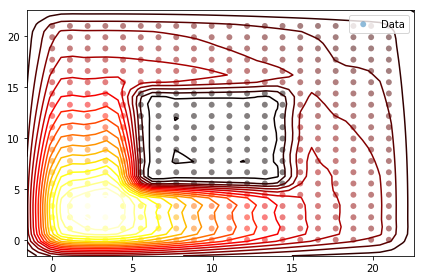

In [20]:
GPS[-4].plot()

In [23]:
print GPS[3].predict(np.array([[1.0,1.0]]))
print p.RGP.predict(np.array([[1.0,1.0]]))

(array([[283.34022114]]), array([[1.35386346]]))
(array([[-3.98383032]]), array([[1.14793316]]))


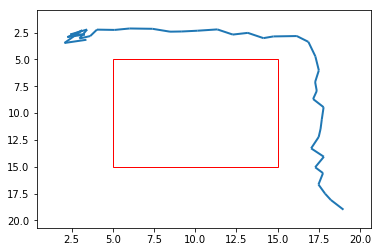

In [8]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc
import matplotlib.patches as patches
lines = []
for i in xrange(len(path)-1):
    lines.append([path[i],path[i+1]])

obstacles = []
for obs in p.obstacles:
    rec = patches.Rectangle((obs.bounds[0],obs.bounds[1]),obs.bounds[2]-obs.bounds[0],obs.bounds[3]-obs.bounds[1],linewidth=1,edgecolor='r',facecolor='none')
    obstacles.append(rec)


lc = mc.LineCollection(lines,linewidths=2)
fig, ax = pl.subplots()
# pl.plot([i[0] for i in path], [i[1] for i in path], 'ro')
for rec in obstacles:
    ax.add_patch(rec)

ax.add_collection(lc)
ax.autoscale()
ax.invert_yaxis()
ax.margins(0.1)